In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product
from tqdm import tqdm

from device_definition import device_definition,  plotting_device_resonances, plotting_device_resonances_iter
from simplified_sequential_assignment import optimal_sequential_assignment, device_resonances_heated_func
from simplified_mrm_crr_cycling import mrm_cycling_func, crr_locking_func
from optimize_mrm_crr_cycling import optimize_overall_heat_func
from copy import deepcopy

## MRM and CRR resonance definition

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=int(2e4+1), centroid_die_variation_bool=False, laser_distribution_uniform=False, die_variation_uniform_bool=False)

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 0

bins = 1001

## Plotting MRM and CRR resonances

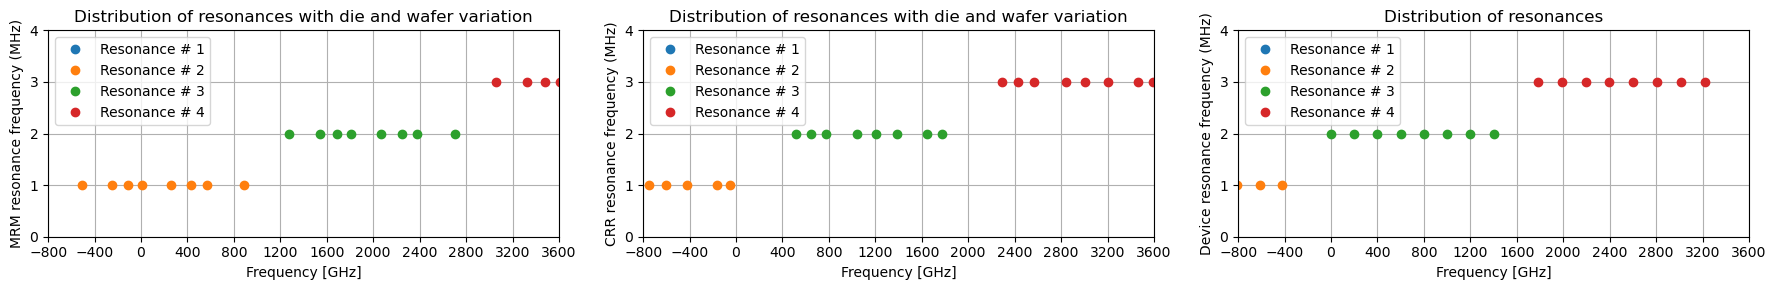

In [3]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## Sequential Assignment of MRM

In [4]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, mrm_resonances_die_wafer_variation.shape[2]))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

for iter_no in tqdm(range(mrm_resonances_die_wafer_variation.shape[2])):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]
  if debug:
    print("\n")
    print("Iteration number", iter_no)
  device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
  heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
  heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
    
  optimized_heat = deepcopy(heat_assigned)
  mrm_lock_data[:, 0, iter_no] = device_dict["device_assigned"]
  mrm_lock_data[:, 1, iter_no] = device_dict["laser_assigned"]
  mrm_lock_data[:, 2, iter_no] = heat_assigned
  mrm_lock_data[:, 3, iter_no] = heat_applied
  mrm_lock_data[:, 4, iter_no] = device_dict["resonance_assigned"]
  mrm_lock_data[:, 5, iter_no] = device_dict["heat_cycling"]
  mrm_lock_data[:, 6, iter_no] = device_dict["cool_cycling"]
  
  if len(np.unique(device_dict["laser_assigned"])) == 8:
    mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths", len(mrm_sequential_success_metric)/mrm_resonances_die_wafer_variation.shape[2]*100, "%")


100%|██████████| 20001/20001 [00:02<00:00, 7708.43it/s]

Successful sequential alignment of MRM to laser wavelengths 100.0 %


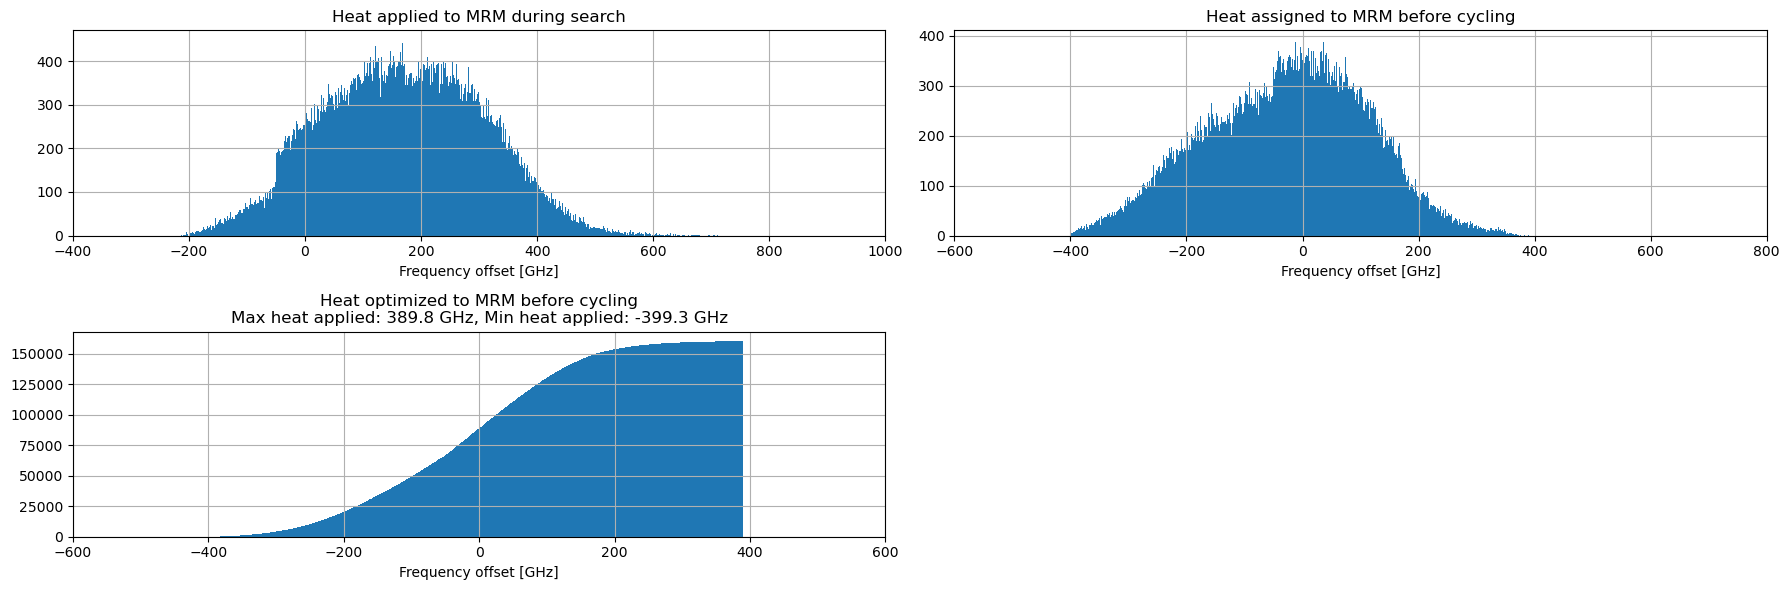

In [5]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.hist(mrm_lock_data[:, 3, :].flatten(), density=False, bins=bins)
plt.xlim([-400, 1000])
plt.grid()
plt.title("Heat applied to MRM during search")
plt.xlabel("Frequency offset [GHz]")
plt.subplot(222)
plt.hist(mrm_lock_data[:, 2, :].flatten(), density=False,  bins=bins)
plt.xlim([-600, 800])
plt.title("Heat assigned to MRM before cycling")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.subplot(223)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=False,  bins=bins)
plt.xlim([-600, 600])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz, "+f"Min heat applied: {np.min(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.show()


In [6]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
  if np.min(mrm_lock_data[:, 2, iter_no]) > 000:
    print("Iteration number", iter_no)
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    break

Iteration number 38
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [4. 3. 7. 2. 6. 1. 5. 0.]
Heat assigned: [301.15086228 107.63768593 148.87286345  57.87826925  51.20469715
 142.48478891 170.3215512   32.43380676]
Heat applied: [301.15086228 507.63768593 358.87286345 253.87826925 249.20469715
 350.48478891 356.3215512  252.43380676]
Resonance assigned: [2. 2. 3. 2. 3. 2. 3. 2.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


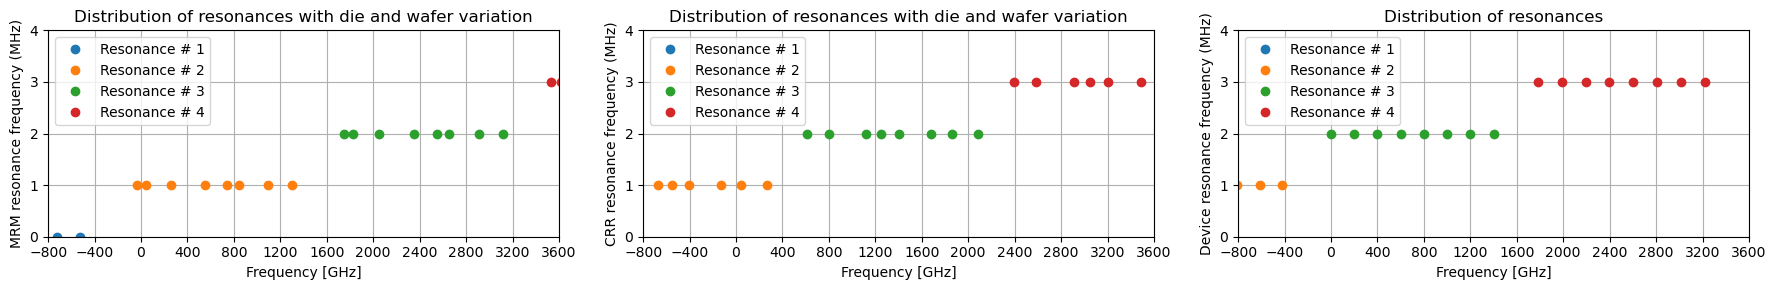

In [7]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

In [8]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
  if np.min(mrm_lock_data[:, 2, iter_no]) < -300:
    print("Iteration number", iter_no)
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    break

Iteration number 2
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [0. 4. 3. 7. 2. 6. 1. 5.]
Heat assigned: [  84.87832227  -91.0667024  -183.91436074 -242.52596489 -134.19916598
 -183.20261585 -305.40646614 -227.62644829]
Heat applied: [ 84.87832227 124.9332976  216.08563926 -38.52596489  67.80083402
   8.79738415 -91.40646614 -47.62644829]
Resonance assigned: [2. 3. 3. 4. 3. 4. 3. 4.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


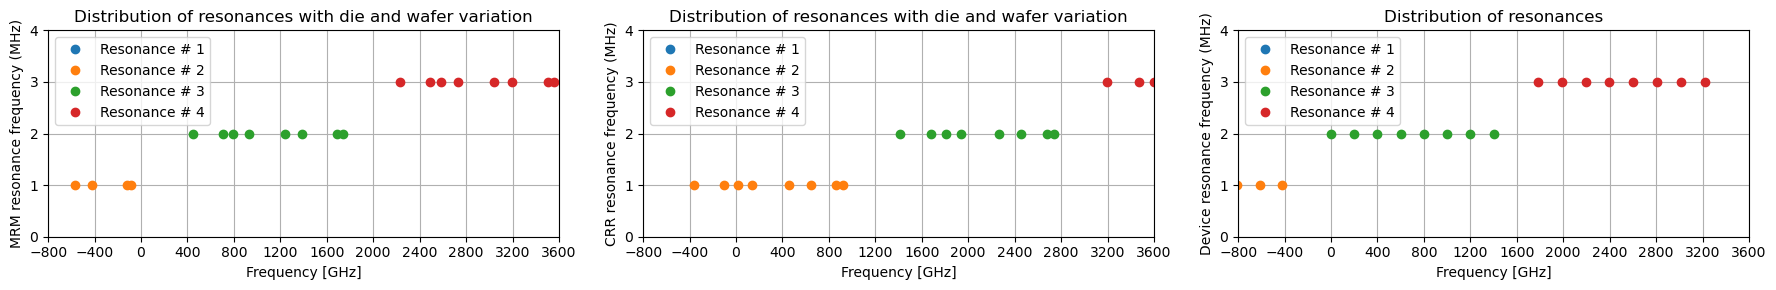

In [9]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## MRM and CRR cycling

In [10]:
mrm_lock_post_cycling_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 6, mrm_resonances_die_wafer_variation.shape[2]))
crr_lock_post_cycling_data = np.zeros((crr_resonances_die_wafer_variation.shape[0], 8, crr_resonances_die_wafer_variation.shape[2]))

post_optimization_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 5, mrm_resonances_die_wafer_variation.shape[2]))

crr_lock_success_metric = []
iter_satisfaction = []

sign_iter = []
optimization_iter_list = []

crr_laser_assigned = []
crr_sequential_assigned = []

no_mrm_cycling_steps = 5
no_crr_cycling_steps = 7
          
for iter_no in tqdm(range(crr_resonances_die_wafer_variation.shape[2])):
  crr_resonances_iter = crr_resonances_die_wafer_variation[:, :, iter_no]
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

  mrm_heat_cycling = mrm_lock_data[0, 5, iter_no]

  mrm_assigned = mrm_lock_data[:, 0, iter_no]
  mrm_laser_assigned =  mrm_lock_data[:, 1, iter_no]
  mrm_heat_assigned = mrm_lock_data[:, 2, iter_no]
  
  if debug:
    print("\n")
    print("Iteration number", iter_no)
  
  cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
  
  cycled_mrm_heat_assigned = []
  for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
    heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
    cycled_mrm_heat_assigned.append(heat_applied_cycled)
  
  sign_iter.append(0)
  optimization_iter_list.append(0)
  
  
  for optimization_iter in np.arange(1,9, 1):
    if (np.max(cycled_crr_dict["crr_heat_assigned"]) > 1000):
      mrm_heat_cycling = mrm_lock_data[0, 5, iter_no] - optimization_iter* 0.5
      optimization_iter_list[-1] = -optimization_iter
      cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
      cycled_mrm_heat_assigned = []
      for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
        heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
        cycled_mrm_heat_assigned.append(heat_applied_cycled)
    if (np.min(cycled_mrm_heat_assigned) < -400):
          mrm_heat_cycling = mrm_lock_data[0, 5, iter_no] - optimization_iter * 0.5 + 0.5
          optimization_iter_list[-1] = - optimization_iter * 0.5 + 0.5
          cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
          cycled_mrm_heat_assigned = []
          for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
            heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
            cycled_mrm_heat_assigned.append(heat_applied_cycled)
          break
  
  
  for optimization_iter in np.arange(1, 9, 1):
      if (np.max(cycled_crr_dict["crr_heat_assigned"]) > 1200):
            sign_iter[-1] = 1
            optimization_iter_list[-1] = optimization_iter
            mrm_heat_cycling = mrm_lock_data[0, 5, iter_no] + optimization_iter
            cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
            cycled_mrm_heat_assigned = []
            for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
              heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
              cycled_mrm_heat_assigned.append(heat_applied_cycled)
      if np.max(cycled_mrm_heat_assigned) > 900:
            sign_range = [0.25, 0.5, 0.75, 1.0, -0.25, -0.5, -0.75, -1.0]
            for sign in sign_range:
              sign_iter[-1] = 2
              optimization_iter_list[-1] = optimization_iter + sign
              mrm_heat_cycling = mrm_lock_data[0, 5, iter_no] + optimization_iter_list[-1]
              cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
              cycled_mrm_heat_assigned = []
              for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
                heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
                cycled_mrm_heat_assigned.append(heat_applied_cycled)
              if np.max(cycled_mrm_heat_assigned) < 900:
                    break
            break
  if (np.min(cycled_crr_dict["crr_heat_assigned"]) < -400):
    sign_range = [0.25, 0.5, 0.75, 1.0]
    for sign in sign_range:   
      mrm_heat_cycling = mrm_heat_cycling + sign
      cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
      cycled_mrm_heat_assigned = []
      for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
        heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
        cycled_mrm_heat_assigned.append(heat_applied_cycled)
      if np.min(cycled_crr_dict["crr_heat_assigned"]) > -400:
           break
    
  if len(cycled_crr_dict["crr_assigned"]) == crr_resonances_die_wafer_variation.shape[0]:  
    crr_lock_post_cycling_data[:, 0, iter_no] = cycled_crr_dict["crr_assigned"]
    crr_lock_post_cycling_data[:, 1, iter_no] = cycled_crr_dict["crr_laser_assigned"]
    crr_lock_post_cycling_data[:, 2, iter_no] = cycled_crr_dict["crr_heat_assigned"]
    crr_lock_post_cycling_data[:, 3, iter_no] = cycled_crr_dict["crr_resonance_assigned"]
    crr_lock_post_cycling_data[:, 4, iter_no] = cycled_crr_dict["crr_cycling_assigned"]
    crr_lock_post_cycling_data[:, 5, iter_no] = cycled_crr_dict["mrm_cycling_assigned"]
    
    cycled_mrm_heat_assigned = []
    for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
      heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
      cycled_mrm_heat_assigned.append(heat_applied_cycled)
    
    mrm_lock_post_cycling_data[:, 0, iter_no] = cycled_mrm_dict["cycled_mrm_assigned"]
    mrm_lock_post_cycling_data[:, 1, iter_no] = cycled_mrm_dict["cycled_mrm_laser_assigned"]
    mrm_lock_post_cycling_data[:, 2, iter_no] = cycled_mrm_heat_assigned
    mrm_lock_post_cycling_data[:, 3, iter_no] = cycled_mrm_dict["cycled_mrm_resonance_assigned"]
    mrm_lock_post_cycling_data[:, 4, iter_no] = cycled_mrm_dict["cycled_mrm_heat_cycling"]
    mrm_lock_post_cycling_data[:, 5, iter_no] = mrm_lock_post_cycling_data[:, 2, iter_no] - mrm_lock_post_cycling_data[0, 2, iter_no]
    
    heat_array = np.array(cycled_crr_dict["crr_heat_assigned"])
    for heat_no, heat_val in enumerate(heat_array):
      if heat_val >= 1000 and np.min(heat_array) < 000:
        heat_array[heat_no] = heat_val - 1800
    crr_lock_post_cycling_data[:, 2, iter_no] = heat_array
    crr_lock_post_cycling_data[:, 6, iter_no] = heat_array - np.min(heat_array)
    crr_lock_post_cycling_data[:, 7, iter_no] = crr_lock_post_cycling_data[:, 2, iter_no] - crr_lock_post_cycling_data[0, 2, iter_no]
        
    post_optimization_data[:, 0, iter_no] = cycled_mrm_dict["cycled_mrm_assigned"]
    post_optimization_data[:, 1, iter_no] = cycled_mrm_dict["cycled_mrm_laser_assigned"]
    post_optimization_data[:, 2, iter_no] = cycled_crr_dict["crr_assigned"]
    post_optimization_data[:, 3, iter_no] = cycled_crr_dict["crr_laser_assigned"]
    post_optimization_data[:, 4, iter_no] = np.array(mrm_lock_post_cycling_data[:, 2, iter_no]) - np.array(crr_lock_post_cycling_data[0, 6, iter_no])
  
  if len(np.unique(cycled_crr_dict["crr_laser_assigned"])) == 8:
    crr_lock_success_metric.append(iter_no)
  else:
    cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_assigned, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = 1)
    break
        

print("Successful locking of CRRs to MRMs", len(crr_lock_success_metric)/crr_resonances_die_wafer_variation.shape[2]*100, "%")


100%|██████████| 20001/20001 [00:52<00:00, 378.88it/s]

Successful locking of CRRs to MRMs 100.0 %


In [11]:
mrm_heat_assigned_checked_crr_hot = []
crr_heat_assigned_checked_crr_hot = []

mrm_heat_assigned_checked_crr_cold = []
crr_heat_assigned_checked_crr_cold = []
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
      if np.max(crr_lock_post_cycling_data[:, 2, iter_no]) > 1200:
            print("\n")
            print("Iteration number", iter_no)
            print("MRM heat assigned", mrm_lock_post_cycling_data[:, 2, iter_no])
            print("CRR heat assigned", crr_lock_post_cycling_data[:, 2, iter_no])
            print("Sign", sign_iter[iter_no])
            print("Optimization iter", optimization_iter_list[iter_no])
            # mrm_heat_assigned_checked_crr_hot.append(np.max(mrm_lock_post_cycling_data[:, 2, iter_no]))
            # crr_heat_assigned_checked_crr_hot.append(np.max(crr_lock_post_cycling_data[:, 2, iter_no]))
            mrm_heat_assigned_checked_crr_hot.append((mrm_lock_post_cycling_data[:, 2, iter_no]))
            crr_heat_assigned_checked_crr_hot.append((crr_lock_post_cycling_data[:, 2, iter_no]))
      else:
            # mrm_heat_assigned_checked_crr_cold.append(np.max(mrm_lock_post_cycling_data[:, 2, iter_no]))
            # crr_heat_assigned_checked_crr_cold.append(np.max(crr_lock_post_cycling_data[:, 2, iter_no]))
            mrm_heat_assigned_checked_crr_cold.append((mrm_lock_post_cycling_data[:, 2, iter_no]))
            crr_heat_assigned_checked_crr_cold.append((crr_lock_post_cycling_data[:, 2, iter_no]))

mrm_heat_assigned_checked_crr_hot = np.array(mrm_heat_assigned_checked_crr_hot).flatten()
crr_heat_assigned_checked_crr_hot = np.array(crr_heat_assigned_checked_crr_hot).flatten()
mrm_heat_assigned_checked_crr_cold = np.array(mrm_heat_assigned_checked_crr_cold).flatten()
crr_heat_assigned_checked_crr_cold = np.array(crr_heat_assigned_checked_crr_cold).flatten()



Iteration number 1763
MRM heat assigned [372.96395647 169.18569135 281.09606717 299.64211733 223.5176273
 162.6267696  153.35388258 293.5656037 ]
CRR heat assigned [1292.31418125 1355.64792734 1369.34740461 1219.43697115 1220.93729116
 1279.57576761 1261.23170667 1427.59949218]
Sign 2
Optimization iter 1.0


Iteration number 1948
MRM heat assigned [289.00613745 178.67553085 153.9186258  237.96052321 184.2582528
 269.38088667 121.18796259  22.69467673]
CRR heat assigned [1070.74644925 1327.201487   1415.14260115 1262.20311598 1369.41371138
 1284.12697637 1330.05332695 1358.94662012]
Sign 2
Optimization iter 1.5


Iteration number 8571
MRM heat assigned [303.84869533 200.07472377 341.78054099 345.73385319 283.68842148
 330.18477109 182.28401886 274.7673892 ]
CRR heat assigned [1291.35532578 1333.72766188 1277.82799108 1376.46836541 1306.22954573
 1350.85341607 1436.97059699 1362.6996349 ]
Sign 2
Optimization iter 1.75


Iteration number 9224
MRM heat assigned [273.48272475 298.06693897

In [12]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
      if np.max(mrm_lock_post_cycling_data[:, 2, iter_no]) > 900:
            print("\n")
            print("Iteration number", iter_no)
            print("MRM heat assigned", mrm_lock_post_cycling_data[:, 2, iter_no])
            print("CRR heat assigned", crr_lock_post_cycling_data[:, 2, iter_no])

In [13]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
      if np.max(mrm_lock_post_cycling_data[:, 2, iter_no]) < -400:
            print("\n")
            print("Iteration number", iter_no)
            print("MRM heat assigned", mrm_lock_post_cycling_data[:, 2, iter_no])
            print("CRR heat assigned", crr_lock_post_cycling_data[:, 2, iter_no])
            print("Sign", sign_iter[iter_no])

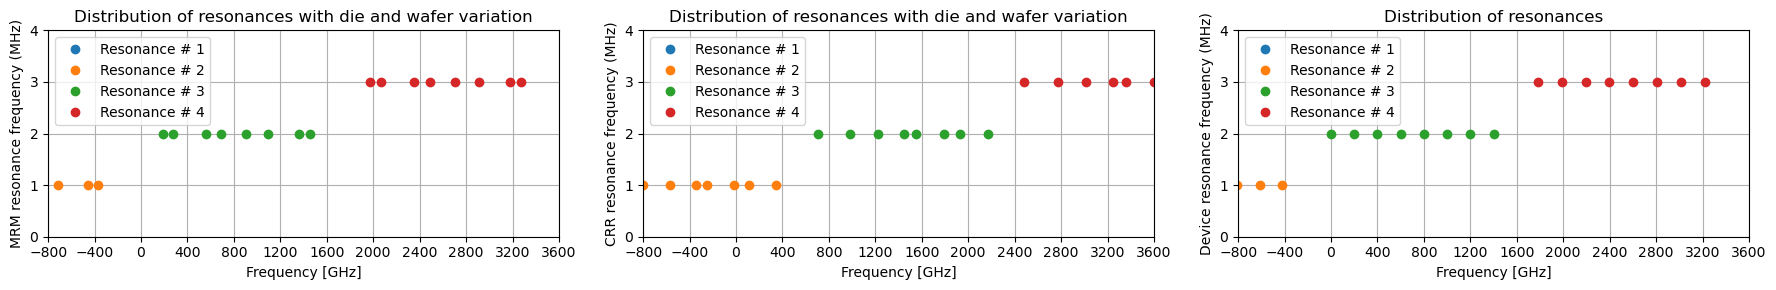

In [14]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

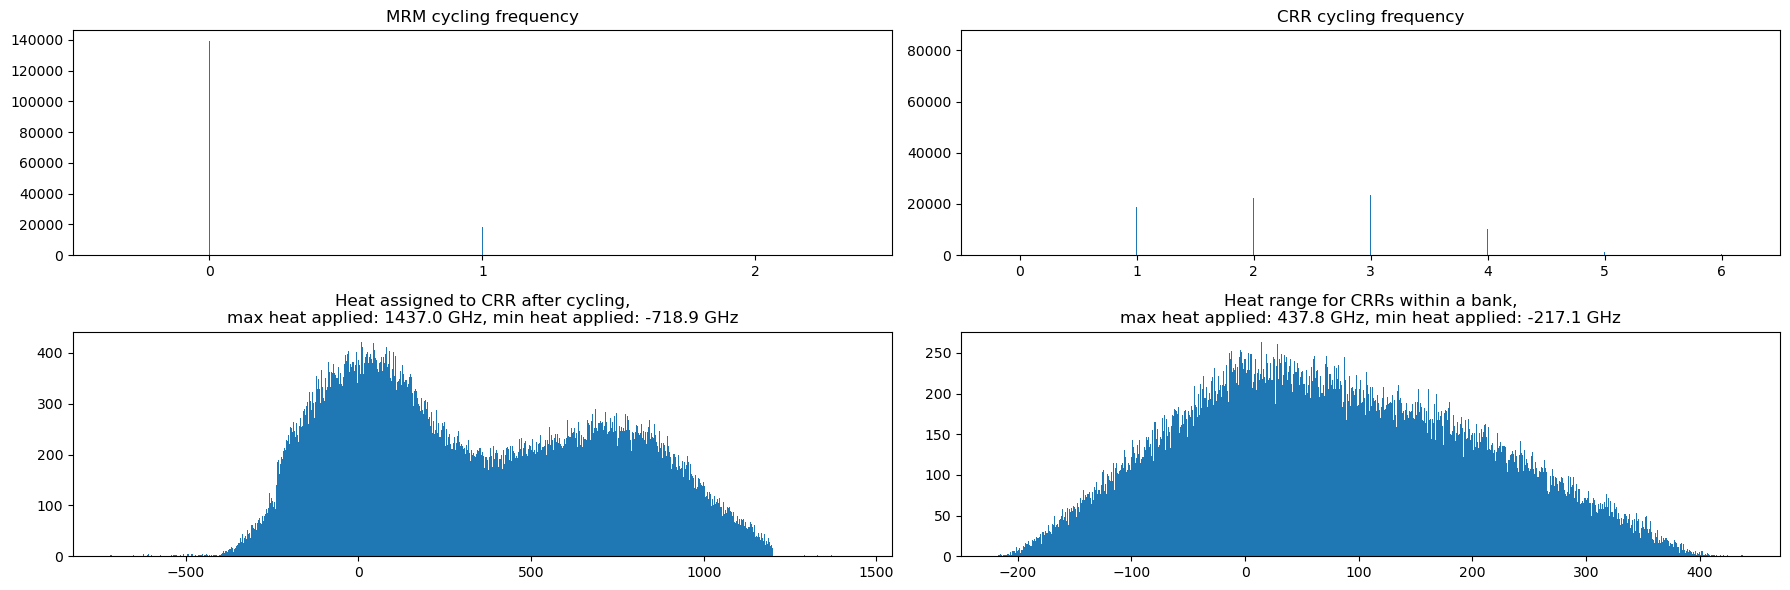

In [15]:
fig = plt.figure(figsize=(18,6))

plt.subplot(221)
plt.hist(crr_lock_post_cycling_data[:, 5, :].flatten(), density=False, bins=bins)
plt.title("MRM cycling frequency")
plt.xlim([-0.5, 2.5])
plt.xticks([0, 1, 2])

plt.subplot(222)
plt.hist(crr_lock_post_cycling_data[:, 4, :].flatten(), density=False, bins=bins)
plt.title("CRR cycling frequency")
plt.xlim([-0.5, 6.5])

plt.subplot(223)
plt.hist(crr_lock_post_cycling_data[:, 2, :].flatten(), density=False, bins=bins)
plt.title(f"Heat assigned to CRR after cycling,\nmax heat applied: {np.max(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz, min heat applied: {np.min(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz")

plt.subplot(224)
plt.hist(crr_lock_post_cycling_data[1:-1, 7, :].flatten(), density=False, bins=bins)
plt.title(f"Heat range for CRRs within a bank,\nmax heat applied: {np.max(crr_lock_post_cycling_data[1:-1, 7, :]):0.1f} GHz, min heat applied: {np.min(crr_lock_post_cycling_data[1:-1, 7, :]):0.1f} GHz")

plt.tight_layout()
plt.show()

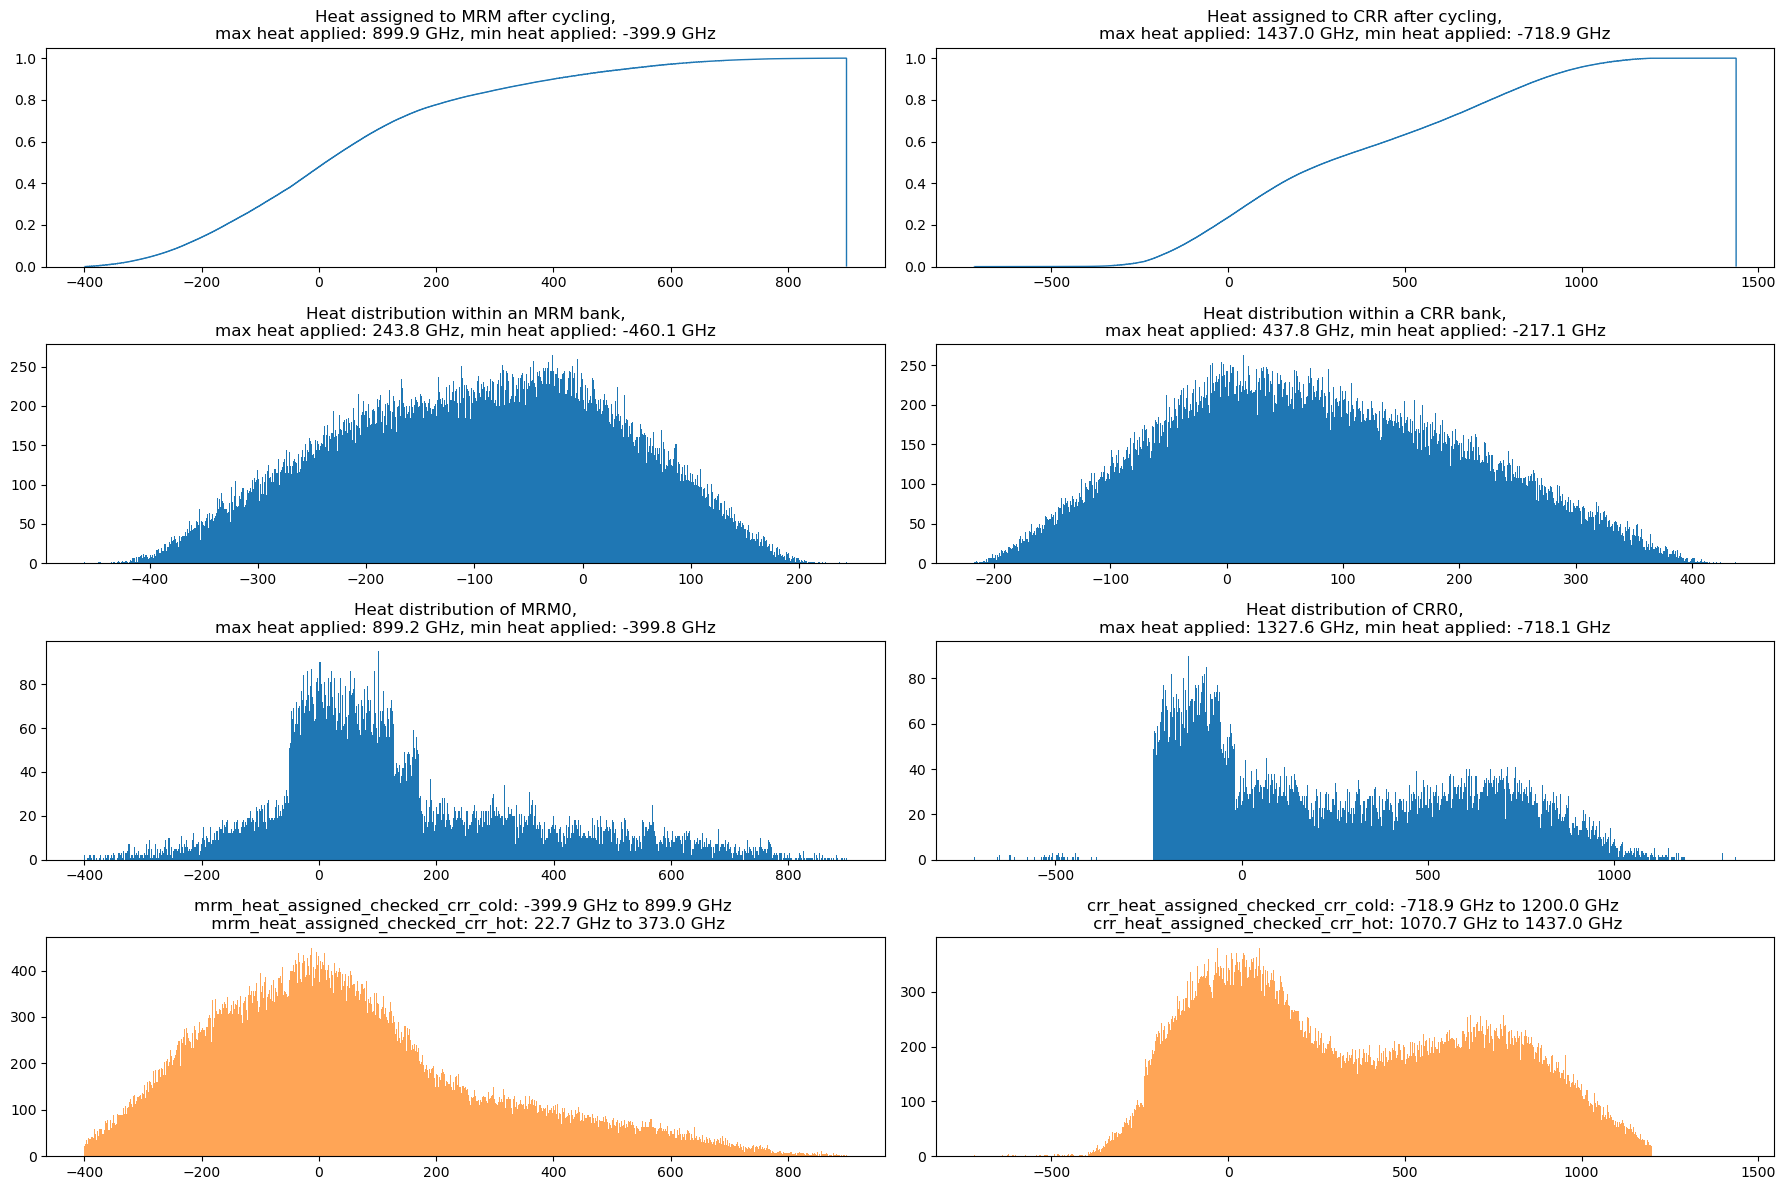

In [16]:
fig = plt.figure(figsize=(18,12))

plt.subplot(421)
plt.hist(mrm_lock_post_cycling_data[:, 2, :].flatten(), density=True, cumulative=True, bins=bins, histtype='step')
plt.title(f"Heat assigned to MRM after cycling,\nmax heat applied: {np.max(mrm_lock_post_cycling_data[:, 2, :]):0.1f} GHz, min heat applied: {np.min(mrm_lock_post_cycling_data[:, 2, :]):0.1f} GHz")

plt.subplot(422)
plt.hist(crr_lock_post_cycling_data[:, 2, :].flatten(), density=True, cumulative=True, bins=bins, histtype='step')
plt.title(f"Heat assigned to CRR after cycling,\nmax heat applied: {np.max(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz, min heat applied: {np.min(crr_lock_post_cycling_data[:, 2, :]):0.1f} GHz")

plt.subplot(423)
plt.hist(mrm_lock_post_cycling_data[1:-1, 5, :].flatten(), density=False, bins=bins)
plt.title(f"Heat distribution within an MRM bank,\nmax heat applied: {np.max(mrm_lock_post_cycling_data[1:-1, 5, :]):0.1f} GHz, min heat applied: {np.min(mrm_lock_post_cycling_data[1:-1, 5, :]):0.1f} GHz")

plt.subplot(424)
plt.hist(crr_lock_post_cycling_data[1:-1, 7, :].flatten(), density=False, bins=bins)
plt.title(f"Heat distribution within a CRR bank,\nmax heat applied: {np.max(crr_lock_post_cycling_data[1:-1, 7, :]):0.1f} GHz, min heat applied: {np.min(crr_lock_post_cycling_data[1:-1, 7, :]):0.1f} GHz")

plt.subplot(425)
plt.hist(mrm_lock_post_cycling_data[0, 2, :].flatten(), density=False, bins=bins)
plt.title(f"Heat distribution of MRM0,\nmax heat applied: {np.max(mrm_lock_post_cycling_data[0, 2, :]):0.1f} GHz, min heat applied: {np.min(mrm_lock_post_cycling_data[0, 2, :]):0.1f} GHz")

plt.subplot(426)
plt.hist(crr_lock_post_cycling_data[0, 2, :].flatten(), density=False, bins=bins)
plt.title(f"Heat distribution of CRR0,\nmax heat applied: {np.max(crr_lock_post_cycling_data[0, 2, :]):0.1f} GHz, min heat applied: {np.min(crr_lock_post_cycling_data[0, 2, :]):0.1f} GHz")

plt.subplot(427)
plt.hist(mrm_heat_assigned_checked_crr_hot, alpha=0.7, density=False, bins=bins)
plt.hist(mrm_heat_assigned_checked_crr_cold, alpha=0.7, density=False, bins=bins)
plt.title(f"mrm_heat_assigned_checked_crr_cold: {np.min(mrm_heat_assigned_checked_crr_cold):0.1f} GHz to {np.max(mrm_heat_assigned_checked_crr_cold):0.1f} GHz \n mrm_heat_assigned_checked_crr_hot: {np.min(mrm_heat_assigned_checked_crr_hot):0.1f} GHz to {np.max(mrm_heat_assigned_checked_crr_hot):0.1f} GHz")

plt.subplot(428)
plt.hist(crr_heat_assigned_checked_crr_hot, alpha=0.7, density=False, bins=bins)
plt.hist(crr_heat_assigned_checked_crr_cold, alpha=0.7, density=False, bins=bins)
plt.title(f"crr_heat_assigned_checked_crr_cold: {np.min(crr_heat_assigned_checked_crr_cold):0.1f} GHz to {np.max(crr_heat_assigned_checked_crr_cold):0.1f} GHz \n crr_heat_assigned_checked_crr_hot: {np.min(crr_heat_assigned_checked_crr_hot):0.1f} GHz to {np.max(crr_heat_assigned_checked_crr_hot):0.1f} GHz")

plt.tight_layout()
plt.show()

In [17]:
for iter_no in range(crr_resonances_die_wafer_variation.shape[2]):
  if np.max(crr_lock_post_cycling_data[:, 2, iter_no]) > 1400:
    print("Iteration number", iter_no)
    print("\n MRM assignment")
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    print("\n CRR assignment")
    print("CRR sequence:", crr_lock_post_cycling_data[:, 0, iter_no])
    print("Laser assigned:", crr_lock_post_cycling_data[:, 1, iter_no])
    print("Heat assigned:", crr_lock_post_cycling_data[:, 2, iter_no])
    print("Resonance assigned:", crr_lock_post_cycling_data[:, 3, iter_no])
    print("CRR cycling:", crr_lock_post_cycling_data[:, 4, iter_no])
    print("MRM cycling:", crr_lock_post_cycling_data[:, 5, iter_no])
    break

Iteration number 1763

 MRM assignment
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [7. 2. 6. 1. 5. 0. 4. 3.]
Heat assigned: [ 150.96395647  -14.81430865   71.09606717  103.64211733   25.5176273
  -45.3732304   -32.64611742 -106.4343963 ]
Heat applied: [150.96395647 169.18569135 281.09606717 299.64211733 223.5176273
 162.6267696  153.35388258 293.5656037 ]
Resonance assigned: [3. 2. 3. 2. 3. 2. 3. 3.]
Heat cycling: [1. 1. 1. 1. 1. 1. 1. 1.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]

 CRR assignment
CRR sequence: [0. 1. 2. 3. 4. 5. 6. 7.]
Laser assigned: [4. 0. 5. 1. 6. 2. 7. 3.]
Heat assigned: [1292.31418125 1355.64792734 1369.34740461 1219.43697115 1220.93729116
 1279.57576761 1261.23170667 1427.59949218]
Resonance assigned: [3. 2. 3. 2. 3. 2. 3. 2.]
CRR cycling: [6. 6. 6. 6. 6. 6. 6. 6.]
MRM cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
for iter_no in range(crr_resonances_die_wafer_variation.shape[2]):
  if np.max(crr_lock_post_cycling_data[:, 6, iter_no]) > 1000:
    print("Iteration number", iter_no)
    print("\n MRM assignment")
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    print("\n CRR assignment")
    print("CRR sequence:", crr_lock_post_cycling_data[:, 0, iter_no])
    print("Laser assigned:", crr_lock_post_cycling_data[:, 1, iter_no])
    print("Heat assigned:", crr_lock_post_cycling_data[:, 2, iter_no])
    print("Resonance assigned:", crr_lock_post_cycling_data[:, 3, iter_no])
    print("CRR cycling:", crr_lock_post_cycling_data[:, 4, iter_no])
    print("MRM cycling:", crr_lock_post_cycling_data[:, 5, iter_no])
    break

In [19]:
for iter_no in range(crr_resonances_die_wafer_variation.shape[2]):
  if np.max(crr_lock_post_cycling_data[:, 6, iter_no]) > 1500:
    print("Iteration number", iter_no)
    print("\n MRM assignment")
    print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
    print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
    print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
    print("Heat applied:", mrm_lock_data[:, 3, iter_no])
    print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
    print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
    print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
    print("\n CRR assignment")
    print("CRR sequence:", crr_lock_post_cycling_data[:, 0, iter_no])
    print("Laser assigned:", crr_lock_post_cycling_data[:, 1, iter_no])
    print("Heat assigned:", crr_lock_post_cycling_data[:, 2, iter_no])
    print("Resonance assigned:", crr_lock_post_cycling_data[:, 3, iter_no])
    print("CRR cycling:", crr_lock_post_cycling_data[:, 4, iter_no])
    print("MRM cycling:", crr_lock_post_cycling_data[:, 5, iter_no])
    break

In [20]:
np.savez("mc_mrm_crr_search.npz", mrm_lock_data=mrm_lock_data, mrm_lock_post_cycling_data=mrm_lock_post_cycling_data, crr_lock_post_cycling_data=crr_lock_post_cycling_data)
npzfile = np.load("mc_mrm_crr_search.npz")
sorted(npzfile.files)

['crr_lock_post_cycling_data', 'mrm_lock_data', 'mrm_lock_post_cycling_data']

In [21]:
mrm_lock_data, mrm_lock_post_cycling_data, crr_lock_post_cycling_data = npzfile['mrm_lock_data'], npzfile['mrm_lock_post_cycling_data'], npzfile['crr_lock_post_cycling_data']